# 6.1. 从全连接层到卷积

我们之前讨论的多层感知机十分适合处理表格数据，
其中行对应样本，列对应特征。
对于表格数据，我们寻找的模式可能涉及特征之间的交互，
但是我们不能预先假设任何与特征交互相关的先验结构。

此时，多层感知机可能是最好的选择，
但是，对于高维感知数据，这种缺少结构的网络可能变得不实用。

例如，对于猫狗分类，假设我们有一个足够充分的数据集，
每个图片具有百万级像素，这意味着每次输入都有一百万个维度。
及时把隐藏层维度降低到1000，这个全连接层依旧有
10_000_000 * 10_000个参数。

想要训练这个模型将不可实现。

# 6.1.1. 不变性

想象一下，假设你想从一张图片中找到某个物体。
合理的假设是：无论哪种方法找到这个物体，都应该和物体的位置无关。
理想情况下，我们的系统应该能够利用常识：猪通常不在天上飞，飞机通常不在水里游泳。
但是，如果一只猪出现在图片顶部，我们还是应该认出它。

卷积神经网络正是将“空间不变性（spatial invariance）”的概念系统化，从而基于这个模型使用较少的参数来学习有用的表示。

# 互相关操作
严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是互相关运算（cross-correlation），而不是卷积运算。

在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。

注意，输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1，
而卷积核只与图像中每个大小完全适合的位置进行互相关运算。

所以，输出大小等于输入大小$n_h, n_w$减去卷积核大小$k_h, k_w$，即
$$(n_h-k_h+1, n_w-k_w+1)$$

In [57]:
import torch
from torch import nn
from d2l import torch as d2l

In [58]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """计算二维互相关运算
    @:param X: 输入
    @:param K： 卷积核
    """
    h, w = K.shape # 卷积核的高和宽
    # 输出Y
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        # print(f'---------当前第{i}行----------')
        # 在输入图像上逐行
        for j in range(Y.shape[1]):
            # 在输入图像上逐列
            # print(f'当前第{j}列')
            # X[i:i + h, j:j + w]和 K等形状，可以直接相乘
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [59]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

![互相关](imgs/互相关.png)

# 卷积层

卷积层对输入和卷积核进行互相关操作，
并在添加标量偏置之后产生输出。

所以卷积层中两个被训练的参数是卷积核权重和变量偏置，
就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也随机初始化卷积核权重。

In [60]:
class Conv2d(nn.Module):
    def __init__(self, kernel_size):
        super.__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

# 图像中目标的边缘检测

如下是卷积层的一个简单应用：通过找到像素变化的位置，来检测图像中不同颜色的边缘。 首先，我们构造一个像素的黑白图像。中间四列为黑色（），其余像素为白色（）。

In [61]:
X = torch.ones((6,8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来，我们构造一个高度为、宽度为的卷积核K。
当进行互相关运算时，
如果水平相邻的两元素相同，则输出为零，否则输出为非零。

In [62]:
K = torch.tensor([[1.0,-1.0]])

In [63]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

输出Y中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘，其他情况的输出为0。

现在我们将输入的二维图像转置，再进行如上的互相关运算。 其输出如下，之前检测到的垂直边缘消失了。 不出所料，这个卷积核K只可以检测垂直边缘，无法检测水平边缘。

In [64]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

# 学习卷积核

如果我们只需寻找黑白边缘，
那么以上[1, -1]的边缘检测器足以。
然而，当有了更复杂数值的卷积核，
或者连续的卷积层时，我们不可能手动设计滤波器。

那么我们是否可以学习由X生成Y的卷积核呢？


现在我们看看是否通过仅查看“输入-输出”对来学习由X生成Y的卷积核。

我们先构造一个卷积层，并将卷积核初始化为随机张量。

接下来，在每次迭代中，我们比较Y与卷积层输出的平方误差，

然后计算梯度来更新卷积核。


In [65]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias=False)

# 这个二维卷积层使用4维输入和输出格式（B，C，H，W）
# 其中B=C=1
X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))
print(X, Y)
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1 )% 2 == 0:
        print(f'epoch {i+1}， loss {l.sum():.3f}')

tensor([[[[1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.]]]]) tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])
epoch 2， loss 4.586
epoch 4， loss 1.472
epoch 6， loss 0.535
epoch 8， loss 0.207
epoch 10， loss 0.083


现在我们来看看我们所学的卷积核的权重张量。

In [66]:
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9637, -1.0228]])

细心的你一定会发现，我们学习到的卷积核权重非常接近我们之前定义的卷积核K。

# 填充和步幅

有时，在我们应用了连续对的卷积之后，我们最终得到的输出远小于输入大小。

这是由于卷积核的宽度和高度大于1所导致的。

比如，一个（240，240）像素的图像，经过层的卷积后，将减少到（200，200）像素。
如此一来，原始图像的边界丢失了许多有用信息。
而填充是解决此问题最有效的方法。

还有时，我们可能希望大幅降低图像的宽度和高度。
例如，如果我们发现原始的输入分辨率十分冗余。步幅则可以在这类情况下提供帮助。

通常，如果我们添加$p_h$行填充（大约一半在顶部，一半在底部），
和$p_w$列填充（一半在左，一半在右），
则输出的形状为
$$(n_h - k_h + p_h + 1) * （n_w - k_w + p_w + 1）$$

这意味着输出的宽度和高度通常会增加$p_h$和$p_w$

在许多情况下，我们要设置

$$p_h = k_h - 1$$

和

$$p_w = k_w - 1$$

这样，经过化简，就可以得到输出的形状为$(n_h, n_w)$保持不变了。

使输入和输出具有相同的高度和宽度。
这样可以在构建网络时更容易地预测每个图层的输出形状

+ 假设卷积核$k_h$是奇数，则$p_h = k_h - 1$是偶数
我们将在高度的两侧填充$p_h / 2$行
+ 假设卷积核$k_h$是偶数，则$p_h = k_h - 1$是奇数
则可能性是在输入顶部填充$\lceil p_h / 2 \rceil$，在底部填充$\lfloor p_h / 2 \rfloor $。

同理，我们填充宽度的两侧。

CNN中卷积核的高度和宽度通常为奇数，例如1，3，5，7。
这样的好处是，在保持空间维度的同时，
我们可以在顶部和底部填充相同数量的行，在左右填充相同数量的列。

比如，在下面的例子中，
我们创建一个高度和宽度为3的二维卷积层，

并在所有侧边填充1个像素。

给定高度和宽度为8的输入，

则输出的高度和宽度也是8

In [67]:
import torch
from torch import nn
# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数

def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示B=C=1
    X = X.reshape((1,1)+X.shape)
    Y = conv2d(X)
    # 省略前两个维度，B和C
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充的1行或1列，因此总共添加了2行2列
conv2d = nn.Conv2d(1,1,kernel_size=3, padding=1)
X = torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

当卷积核的宽和高不一致时，

我们可以填充不同的宽度和高度，使输入和输出具有相同的宽度和高度。

如下，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1

In [68]:
conv2d = nn.Conv2d(1,1, kernel_size=(5,3), padding=(2,1))
comp_conv2d(conv2d, X).shape, X.shape

(torch.Size([8, 8]), torch.Size([8, 8]))

上方也可以看出
$P_w = (5 -1) / 2 \\
P_h = (3-1)/2
$

# 步幅

在计算互相关时，卷积窗口从输入张量的左上角开始，向下、向右滑动。
在前面的例子中，我们默认每次滑动一个元素。
但是，有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。

通常，当垂直步幅为$s_h$，水平步幅为$s_w$时，输出形状为：
$$
\lfloor (n_h - k_h + p_h + s_h) / s_h \rfloor \times \lfloor (n_w - k_w + p_w + s_w) / s_w \rfloor
$$

假设我们设置了$p_h=k_h-1$，和$p_w = k_w -1$

则输出形状简化为
$$
\lfloor (n_h + s_h - 1) / s_h \rfloor \times \lfloor (n_w + s_w - 1) / s_w
$$

更进一步，如果输入的高度与宽度可以被垂直和水平步幅整除，则输出形状为
$$
 (n_h / s_h) \times (n_w / s_w)
$$


下面，我们将高度和宽度的步幅设置为2，从而将输入的宽度和高度减半。

In [69]:
conv2d = nn.Conv2d(1,1,kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

注意这里我们要填充3-1=2列，参数padding应该再除以2

In [70]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# 多输入多输出通道

# 多输入通道

当输入包含多个通道时，

**需要构造一个与输入具有相同输入通道数的卷积核。**

以便与输入数据进行互相关操作。

假设输入的通道数为$c_i$，则卷积核的输入通道数也应该为$c_i$。



如果卷积核的窗口形状是$k_h \times k_w$，
那么当$c_i = 1$时，我们可以把卷积核看作形状为的二维张量。
然而，当$c_i > 1$时，我们卷积核每个输入通道都将包含形状为$k_h \times k_w$的张量。
将这$c_i$个张量连结到一起可以得到形状为$c_i \times k_h \times k_w $的卷积核

由于输入和卷积核都有$c_i$个通道，

我们可以对每个通道输入的二维张量和卷积核的二维张量进行互相关运算，
再对通道求和得到二维张量。

这是多通道输入和多输入通道卷积核之间进行二维互相关运算的结果。

![多通道卷积](imgs/多通道卷积.png)

In [71]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X,K):
    # 先遍历X和K的第0个维度（通道维度），再将它们架在一起
    return sum(corr2d(x, k) for x, k in zip(X, K))

In [72]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [73]:
print(X.shape, K.shape)

torch.Size([2, 3, 3]) torch.Size([2, 2, 2])


# 多输出通道
到目前为止，不论有多少输入通道，我们还只有一个输出通道。
然而，每一层有多个输出通道是至关重要的。

在最流行的神经网络架构中，随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。

直观来说，我们可以把每个通道看作对不同特征的响应。
而现实可能会更复杂一点，因为每个通道不是独立学习的，
而是为了共同使用而优化的。

因此，多输出通道并不仅是学习多个单通道的检测器。

用$c_i$和$c_o$分别表示输入和输出通道的数目，
并让$k_h$和$k_w$作为卷积核的高度和宽度。


为了获得多个通道的输出，我们可以为

每一个输出通道创建一个$c_i \times k_h \times k_w$的卷积核张量。

这样卷积核的形状是$c_o \times c_i \times k_h \times k_w$

在互相关运算中，每个输出通道先获取所有输入通道，再以对应输出通道的卷积核计算出结果。

下面，实现一个计算多通道输出的互相关函数。

In [74]:
def corr2d_multi_in_out(X, K):
    # 迭代K的第0个维度，每次都对输入X执行互相关
    # 最后将结果都叠加到一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

通过将核张量K与K+1（K中每一个元素加1）和K+2连接起来，构造了一个具有3个输出维度的卷积核。

In [75]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

下面，我们对输入张量X和卷积核张量K执行互相关操作。
现在输出包含3个通道，

第一个通道的结果与先前输入张量X和多输入单输出通道的结果一致。

In [76]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

# $1 \times 1$卷积

1 × 1卷积，即$k_h = k_w = 1$

看起来似乎没有任何意义。
毕竟，
卷积的本质，

是有效提取相邻像素之间的相关特征。

但是

因为使用了最小窗口，1 × 1 卷积失去了卷积层的特有能力

 ----- 在高度与宽度维度上，识别相邻元素间相互作用的能力。
其实，
1 × 1卷积的唯一计算发生在通道上。

![1x1卷积](imgs/1x1卷积.png)

上图展示了使用 1 × 1卷积核 与 3个输入通道和2个输出通道的互相关操作。

这里输入和输出具有相同的高度和宽度。

输出中每个元素都是从输入图像中同一位置的元素的线性组合。

我们可以把 1 × 1 卷积层看作在每个像素位置应用的全连接层，

以$c_i$个输入值转换为$c_o$个输出值。

因为这仍旧是一个卷积层，所以跨像素的权重是一致的。

同时，1 × 1 卷积层需要的权重维度为$c_o \times c_i$，再额外添加一个偏置。

下面，我们使用全连接层实现卷积。 请注意，我们需要对输入和输出的数据形状进行调整。

In [77]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape # 输入的通道，高，宽
    c_o = K.shape[0] # 需要的输出维度
    X = X.reshape((c_i, h * w)) # 输入转为2维度 -- 方便矩阵乘法
    K = K.reshape((c_o,  c_i)) # 卷积核也转为2维
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K,X)
    return Y.reshape((c_o, h, w))

当执行1×1卷积运算时，上述函数相当于先前实现的互相关函数corr2d_multi_in_out。让我们用一些样本数据来验证这一点

In [78]:
X = torch.normal(0, 1, (3,3,3)) # 输入 通道3 高3 宽3
K = torch.normal(0,1, (2,3,1,1)) # 卷积核 需要两个输出， 通道3 高1 宽1
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X,K)
Y1 - Y2

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

# 汇聚层（池化层）

通常当我们处理图像时，

我们希望逐渐降低隐藏表示的空间分辨率、聚集信息，
这样随着我们在神经网络中层叠的上升，每个神经元对其敏感的感受野（输入）就越大。



1. 我们的机器学习任务通常跟全局的图像有关
2. 拍摄一个静止的物体，由于快门的移动而引起的相机振动，可能会使所有物体左右移动一个像素

# 汇聚（pooling）层，
它具有双重目的：
+ 降低卷积层对位置的敏感性
+ 降低对空间降采样表示的敏感性。
      如果我们拍摄黑白之间轮廓清晰的图像X，并将整个图像向右移动一个像素，即Z[i, j] = X[i, j + 1]，

# 最大池化
![最大池化](imgs/最大池化.png)

回到前面所说的对象边缘检测示例，
现在我们使用卷积层的输出作为 2 × 2 最大汇聚的输入。

设置卷积层输入为X，汇聚层输出为Y。
无论X[i,j]和X[i, j+1]的值是否相同，
或X[i,j+1]和X[i,j+2]的值是否相同，
汇聚层始终使出Y[i,j]=1。

也就是说，使用2 × 2最大汇聚层，即使在高度和宽度上移动一个元素，
卷积层依旧可以识别到模式。

In [79]:
import torch
from torch import nn
from d2l import torch as d2l

In [80]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    # 先把输入Y形状设置好
    # 输出的形状，同样类似与卷积 N - K + 1
    Y = torch.zeros(
        (X.shape[0] - p_h + 1, X.shape[1] - p_w + 1)
    )
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i+p_h, j: j+p_w].max()
            elif mode =='avg':
                Y[i, j ] = X[i:i+p_h, j: j+p_w].mean()
    return Y

In [81]:
X = torch.tensor(
    [[0.0, 1.0, 2.0],
     [3.0, 4.0, 5.0],
     [6.0, 7.0, 8.0]]
)
pool2d(X,(2,2))

tensor([[4., 5.],
        [7., 8.]])

In [82]:
pool2d(X,(2,2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

# 填充与步幅

与卷积层一样，汇聚层也可以改变输出形状。和以前一样，我们可以通过填充和步幅以获得所需的输出形状。

In [83]:
X = torch.arange(16, dtype=torch.float32).reshape((1,1,4,4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，深度学习框架中的

**步幅与汇聚窗口的大小相同**

因此，如果我们使用（3，3）的汇聚窗口，那么默认情况下，步幅也是(3,3)

In [84]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [85]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [86]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

# 多个通道

在处理多通道输入数据时，汇聚层在每个输入通道上单独运算。
而不是像卷积层一样在通道上对输入进行汇总。

下面，我们在通道上连结张量X和X+1，以构建具有两个通道的输入

In [87]:
X = torch.arange(16, dtype=torch.float32).reshape((1,1,4,4))
torch.cat((X, X+1),dim=1).shape # 在通道维度拼接

torch.Size([1, 2, 4, 4])

In [88]:
torch.cat((X, X+1),dim=0).shape # 在Batch维度拼接

torch.Size([2, 1, 4, 4])

In [89]:
X = torch.cat((X, X+1),dim=1)

In [90]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X).shape

torch.Size([1, 2, 2, 2])

# LeNet

![LeNet](imgs/LeNet.png)

In [91]:
import torch
from torch import nn
from d2l import torch as d2l
from torchsummary import summary
net = nn.Sequential(
    # 输入 1 *  28 * 28

    # 第一层卷积，尺度没有发生变化，通道数增加
    nn.Conv2d(1,6,kernel_size=5, padding=2,), # 6 * 28 * 28
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2), # 6 * 14 * 14
    nn.Conv2d(6,16,kernel_size=5), # 16 * (14 - 5 + 1) * (14 - 5 + 1)
    nn.Sigmoid(), # 16 * 10 * 10
    nn.AvgPool2d(kernel_size=2, stride=2), # 16 * floor[(10 - 2 + 1 + 2) / 2 ]* floor[(10 - 2 + 1 + 2) / 2 ]= 16 * 5 * 5
    nn.Flatten(), # 16 * 5 * 5
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)


In [92]:
print(summary(net, input_size=(1, 28, 28), batch_size=1, device='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 6, 28, 28]             156
           Sigmoid-2             [1, 6, 28, 28]               0
         AvgPool2d-3             [1, 6, 14, 14]               0
            Conv2d-4            [1, 16, 10, 10]           2,416
           Sigmoid-5            [1, 16, 10, 10]               0
         AvgPool2d-6              [1, 16, 5, 5]               0
           Flatten-7                   [1, 400]               0
            Linear-8                   [1, 120]          48,120
           Sigmoid-9                   [1, 120]               0
           Linear-10                    [1, 84]          10,164
          Sigmoid-11                    [1, 84]               0
           Linear-12                    [1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

# 参数量计算
[卷积参数量计算](https://blog.csdn.net/weixin_38632246/article/details/103177846)
$$(C_{in} * (K * K) + 1) * C_{out}$$
1. Conv2d-1普通卷积
    (1*(5*5)+1)*6 = 156

In [93]:
(1*(5*5)+1)*6

156

In [98]:
# for layer in net:
#     X = layer(X)
#     print(layer.__class__.__name__, 'output shape: \t', X.shape)

# 模型训练

In [99]:
batch_size = 256

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

为了进行评估

In [100]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    # ccumulator，
    # 用于对多个变量进行累加。
    # Accumulator实例中创建了2个变量， 分别用于存储正确预测的数量和预测的总数量。
    # 当我们遍历数据集时，两者都将随着时间的推移而累加。
    metric = d2l.Accumulator(2)
    # p评估不需要构建计算图，没有grad_fn=<AddmmBackward>属性
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT所需要的微调
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# model.eval()与with torch.no_grad()的区别
model.eval主要用在模型前向传播过程中，
通过设置城eval模式，告诉所有层你在eval模式，其中涉及到BN和Dropout层。这些层在训练和测试的表现是不一样的, 比如 dropout 在训练中可能是0-1间的数, 但在eval模式则为不使用dropout层.

torch.no_grad() 会关闭自动求导引擎的,  因此能节省显存, 和加速.

总结： 如果你的网络中包含batchNorm或者dropout这样在training,eval时表现不同的层，应当使用model.eval()。在inference时用with torch.no_grad()会节省存储空间。

另外需要注意的是，即便不使用with torch.no_grad()，在测试只要你不调用loss.backward()就不会计算梯度，with torch.no_grad()的作用只是节省存储空间。

In [101]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on: ', device)
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    animator = d2l.Animator(
        xlabel='epoch',
        xlim=[1, num_epochs],
        legend=['train loss', 'train acc', 'test acc']
    )

    timer, num_batches = d2l.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        # 训练损失之和
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            # 这里计算的时batch_size个样本的loss均值
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                # 这里只是为了得到batch_size样本的总loss，总acc，以及batch_size
                metric.add(l * X.shape[0], d2l.accuracy(y_hat,y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1 ) % (num_batches // 5) == 0 or i == num_batches-1:
                animator.add(epoch+(i+1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter, device='cpu')
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc:{train_acc:.3f}, test_acc:{test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}  ')



loss 0.658, train acc:0.741, test_acc:0.737
9728.9 examples/sec on cpu  


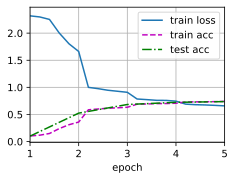

In [102]:
lr, num_epochs = 0.9, 5
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 现代卷积神经网络

 # AlexNet
 ![AlexNet](imgs/AlexNet.png)

In [103]:
import torch
from torch import nn
from d2l import torch as d2l

$$
\lfloor (n_h - k_h + p_h + s_h) / s_h \rfloor \times \lfloor (n_w - k_w + p_w + s_w) / s_w \rfloor
$$

$$(n_h - k_h + p_h + 1)  \times （n_w - k_w + p_w + 1）$$

In [104]:
net = nn.Sequential(
    # 输入 1 * 224 * 224
    # 注意下面计算shape时 padding * 2

    # floor 224 - 11 + 1*2 + 4 / 4 =  [224-11+6]/4 = 219 / 4 = 54
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),

    # 54 - 3 + 2 / 2 = 53 / 2 = 26
    nn.MaxPool2d(kernel_size=3, stride=2),

    # 26 - 5 + 2*2 + 1 = 26
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),

    # 26 - 3 + 2 / 2 = 12
    nn.MaxPool2d(kernel_size=3, stride=2),

    # 12 - 3 + 1 * 2 + 1 = 12
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),

    # 12 - 3 + 1 * 2 + 1 = 12
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),

    # 12 - 3 + 1 * 2 + 1 = 12
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),

    # （12 - 3 + 2） / 2 = 5
    nn.MaxPool2d(kernel_size=3, stride=2),

    # 256 * 5 * 5 = 4600
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [105]:
summary(net, input_size=(1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]         614,656
              ReLU-5          [-1, 256, 26, 26]               0
         MaxPool2d-6          [-1, 256, 12, 12]               0
            Conv2d-7          [-1, 384, 12, 12]         885,120
              ReLU-8          [-1, 384, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]       1,327,488
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         884,992
             ReLU-12          [-1, 256, 12, 12]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
          Flatten-14                 [-

In [106]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [107]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.543, train acc 0.798, test acc 0.801
11.0 examples/sec on cpu


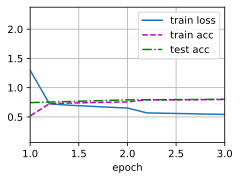

In [ ]:
lr, num_epochs = 0.01, 1
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# VGG
![VGG](imgs/VGG.png)

In [113]:
import torch
from torch import nn
from d2l import torch as d2l

In [114]:
def vgg_block(num_convs, in_channels, out_channels):
    '''

    :param num_convs: 卷积层的数量
    :param in_channels: 输入通道的数量
    :param out_channels: 输出通道的数量
    :return: layers
    '''
    layers = []
    for num in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        layers.append(
            nn.ReLU()
        )
        in_channels = out_channels
    layers.append(
        nn.MaxPool2d(2,stride=2)
    )
    return nn.Sequential(*layers)


上面的代码实现了VGG块，
其中有超参数变量conv_arch指定了每个VGG块里卷积层的个数，和输出通道数

原始的VGG共有5个卷积块，
其中前两个块各有一个卷积层，
后三个块各包含2个卷积层。

第一个模块有64个输出通道，后续输出通道把输出通道数量翻倍。直到512.

由于该网络使用
2 * 1 + 3 * 2 = 8个卷积层
和3个全连接层，
因此它通常被称为VGG-11。

In [115]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2,512), (2, 512))

In [ ]:
def vgg(conv_arch):
    conv_blk = []
    in_channels = 1

    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blk.append(
            vgg_block(num_convs, in_channels, out_channels)
        )
        in_channels = out_channels
    return nn.Sequential(
        *conv_blk,
        nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )
net = vgg(conv_arch)

In [ ]:
X = torch.randn(size=(1,1,224,224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape: ', X.shape)

由于VGG-11比AlexNet计算量更大，
因此我们构建一个通道较少的网络，
足够用来训练Fashion-MNIST数据集

In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

Traceback (most recent call last):
Traceback (most recent call last):
  File "D:\miniconda\lib\multiprocessing\queues.py", line 247, in _feed
    send_bytes(obj)
  File "D:\miniconda\lib\multiprocessing\connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "D:\miniconda\lib\multiprocessing\connection.py", line 285, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] 管道正在被关闭。
  File "D:\miniconda\lib\multiprocessing\queues.py", line 247, in _feed
    send_bytes(obj)
  File "D:\miniconda\lib\multiprocessing\connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "D:\miniconda\lib\multiprocessing\connection.py", line 285, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] 管道正在被关闭。


KeyboardInterrupt: 

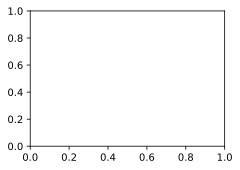

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 网络中的网络NiN

AlexNet，VGG等都有一个共同的设计模式：

通过一系列的卷积和汇聚层来提取空间结构特征；
然后通过全连接层对特征的表征进行处理。

它们的最大改进在于如何扩大和加深这两个模块。

或者，可以想象在这个过程的早期使用全连接层。
然而，使用了全连接层，可能会完全放弃表征的空间结构。

网络中的网络（NiN）提供了一种非常简单的解决方案：

**在每个像素的通道上分别使用多层感知机**

# NiN块

回想一下，卷积层的输入和输出由4维张量组成，
张量的每个轴分别对应样本、通道、高度和宽度。

NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。 如果我们将权重连接到每个空间位置，我们可以将其视为卷积层（

![NiN](./imgs/NiN.png)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


In [ ]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [ ]:
lr, num_epochs, batch_size = 0.1, 1, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
summary(net, input_size=(1,224,224))